In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Individual 

class Individual(object):
    
    #Initializing its genome and fitness
    
    #we need jobs as param. for passing the processing time of each 
    #calculate the fitness
    
    def __init__(self, genome, fitness, jobs):
        
        self.genome = genome
        self.fitness = fitness(genome, jobs)

In [3]:

#Problem class having the parameters that describe the genetic representation of it

class Problem(object):
    
    def __init__(self, machines, jobs, fitnessFunc):
        self.machines = machines
        self.jobs = jobs
        self.fitnessFunc = fitnessFunc


In [4]:


#Initializer having different functions (versions)

class Initializer(object):  
    
    #parameters needed for initializing in general
    
    def __init__(self, problem, pop_size):
        self.problem = problem
        self.pop_size = pop_size
    
    
    
    #Initializing randomly
    
    def random(self):
        
        return [Individual(list(np.random.choice(self.problem.machines, len(self.problem.jobs))), self.problem.fitnessFunc, self.problem.jobs) for member in range(self.pop_size)]            

    
    def heuristic(self):
        #idea of the heuristic: make an educated guess (create a specific number of guesses (limit?))-- sequence see below-- fill up the rest of the searchspace with random  
        #get a list of the jobs
        
        job_list = self.problem.jobs
        
        #order that list from highest to lowest time they consume
        
        sorted_list = list(reversed(sorted(job_list)))
        
        #make the hueristic
        machines = self.problem.machines
        zuordnung = []
        populationpool = []
        
        
        for i in range(self.pop_size//3):
        
            random.shuffle(machines)
        
            while len(zuordnung) < len(sorted_list):
                zuordnung.extend(machines)
                machines = list(reversed(machines))
            zuordnung= zuordnung[0:len(sorted_list)]
        
            chromosome = Individual(zuordnung, self.problem.fitnessFunc, sorted_list)
     
            populationpool.append(chromosome)
        
        
        while len(populationpool)< self.pop_size:
            Individuals = Individual(list(np.random.choice(self.problem.machines, len(self.problem.jobs))), self.problem.fitnessFunc, self.problem.jobs)
            populationpool.append(Individuals)
      
    
        return populationpool
       
        #create a chromosom for the sorted jobs -- so add the machines to the jobs in a sequence example: 1,2,3,4,4,3,2,1,1,......
        




In [5]:
#Selection class having different functions (versions)

class Selector(object):

        
        
        
    #Roulette Wheel selection   
    
    def roulette_wheel(self, population, candidatesSize):
        
        #Sum the all fitnesses of all individuals
        sum_of_fitness = sum([c.fitness for c in population])
        
        #For accumulating the probability for later use
        accumulative_probability = 0.0
        probability = np.zeros(len(population))
        for i, c in enumerate(population):
            probability[i] = accumulative_probability + (c.fitness / sum_of_fitness)
            accumulative_probability = probability[i]
        
        
        #candidates is a list of indices referring to the selected individuals
        candidates =  [0]*candidatesSize
        
        for i in range(candidatesSize):
            rand = random.uniform(0, 1)
            for j in range(len(probability)):
                if rand < probability[j]: 
                    break
            candidates[i] = j
        
        return [population[idx] for idx in candidates]
    
    
    
    # ordial Tournament selection
    def tournament(self, population, candidatesSize):
        candidates = [] # an empty list for canditates that will be selected
        for tournament in range(candidatesSize):
            # create a range of the population indices
            pop_ind = list(range(0,len(population)))
            # shuffle the indices in-place
            random.shuffle(pop_ind)
            # take the first five indices to find the tournament participants
            t_participants = [population[i] for i in pop_ind[0:5]]
            # find the best participant
            fitness_part = [p.fitness for p in t_participants]
            # append the best participant to our list of canditates
            candidates.append(population[pop_ind[fitness_part.index(max(fitness_part))]])  
        return candidates

    
    

In [6]:
#Recombiner having different functions (versions)

class Recombiner(object):
    
    
    #parameters needed for recombination in general
    
    def __init__(self, pc, problem):
        self.pc = pc
        self.problem = problem
    
    
    
    #Single crossover
    
    #We could add a specific param. for offSpring size
    def single_point_crossover(self, mating_pool):
        pool = mating_pool.copy()
        offSpring = []
        for i in range(len(pool)//2):
            mating_parents = np.random.choice(range(len(pool)), 2, replace=False)
            parent1 = pool[mating_parents[0]]
            parent2 = pool[mating_parents[1]]
            cross_rate = random.uniform(0, 1)
            if cross_rate < self.pc :
                cross_point = random.choice(range(1,len(parent1.genome)))
                child1 = Individual(parent1.genome[:cross_point] + parent2.genome[cross_point:], self.problem.fitnessFunc, self.problem.jobs)
                child2 = Individual(parent2.genome[:cross_point] + parent1.genome[cross_point:], self.problem.fitnessFunc, self.problem.jobs)
                offSpring.append(child1)
                offSpring.append(child2)
            else:
                offSpring.append(parent1)
                offSpring.append(parent2)
        return offSpring
    
     # Uniform crossover
    def uniform_crossover(self, mating_pool):
        l = len(mating_pool[1].genome)
        threshold_string = np.random.uniform(0,1,l)
        pool = mating_pool.copy()
        offSpring = []
        for i in range(len(pool)//2):
            mating_parents = np.random.choice(range(len(pool)), 2, replace=False)
            parent1 = pool[mating_parents[0]]
            parent2 = pool[mating_parents[1]]
            dummy_child1 = []
            dummy_child2 = []
            for j in range(l):
                if threshold_string[j] > self.pc:
                    dummy_child1.append(parent1.genome[j])
                    dummy_child2.append(parent2.genome[j])
                else: 
                    dummy_child1.append(parent2.genome[j])
                    dummy_child2.append(parent1.genome[j])
            child1 = Individual(dummy_child1, self.problem.fitnessFunc, self.problem.jobs)
            
            child2 = Individual(dummy_child2, self.problem.fitnessFunc, self.problem.jobs)
            offSpring.append(child1)
            offSpring.append(child2)
        return offSpring

In [7]:
#Mutation class having different kinds of mutators

class Mutation(object):
    
    
    
    # parameters needed for recombination in general
    
    def __init__(self, p, problem):
        self.p = p
        self.problem = problem
    
    
    
    #Random resetting mutation
    
    def random_resetting(self, individuals):
        if type(self.p) != list:
            p = [self.p]*len(individuals[0].genome) 
        mutants = []
        for chr in individuals:
            mutants.append(Individual([random.choice(self.problem.machines) if random.uniform(0, 1)<p[i] else g for i,g in enumerate(chr.genome)], self.problem.fitnessFunc, self.problem.jobs))
        return mutants
    
    
    def creep_mutator(self, individuals):
        if type(self.p) != list:
            p = [self.p]*len(individuals[0].genome) 
        mutated = individuals.copy()
        for chr in mutated:
            for i, g in enumerate(chr.genome):
                rnd1 = random.uniform(0,1)
                if rnd1 < p[i]: 
                    g = g + np.random.randint(-3,4) 
                    if g < 1:
                        g = 1
                    if g > len(chr.genome): 
                        g = len(chr.genome) 
                    chr.genome[i] = g
        return mutated
                
    


In [8]:
# Replacer class


class Replacer(object):
    
    def delete_all_parents(self, population, offspring):
                  return offspring # delete parents by returning offspring only
    
    def elitist_replacer(self, population, offspring): # the weak children die due to climate change
        population.extend(offspring)
        L = len(population)//2 # take 50% of population size
        return sorted(population, key= lambda individual : individual.fitness)[-L:] # return the fitter half of the merged population

      
        

In [9]:
#This class performs genetic algorithm, assuming the same size for the population size, the mating pool,
#and the offspring and it mainly does replace the whole parents with the whole newly generated offspring

class GeneticAlgo(object):
    
    def __init__(self, problem, termination=35, initializer='random', selector='roulette wheel', recombiner='single point crossover', mutator='random resetting', replacer='delete_all', pop_size=300, crossOver_rate=1, mutation_rate=0.09):
        
        self.problem = problem
        self.termination = termination
        self.pop_size = pop_size
        self.initializer = initializer
        self.selector = selector
        self.recombiner = recombiner
        self.mutator = mutator
        self.replacer = replacer
        self.crossOver_rate = crossOver_rate
        self.mutation_rate = mutation_rate
        self.initialization_dict = {'random': Initializer(self.problem, self.pop_size).random(), 'heuristic': Initializer(self.problem, self.pop_size).heuristic()}
        self.selection_dict = {'roulette wheel': Selector().roulette_wheel, 'tournament': Selector().tournament}
        self.recombination_dict = {'single point crossover': Recombiner(self.crossOver_rate, self.problem).single_point_crossover, 'uniform crossover': Recombiner(self.crossOver_rate, self.problem).uniform_crossover}
        self.mutation_dict = {'random resetting': Mutation(self.mutation_rate, self.problem).random_resetting, 'creep mutator': Mutation(self.mutation_rate, self.problem).creep_mutator}
        self.replacer_dict = {'delete_all': Replacer().delete_all_parents, 'elitist_replacer': Replacer().elitist_replacer}

        
    
    def top_individual(self, population):
        
        return sorted(population, key= lambda individual : individual.fitness)[-1]
    
    
    def evolve(self):
        population = self.initialization_dict[self.initializer]
        
        top_individual = self.top_individual(population)
        
        count = 0
        
        #For monitoring
        top_individuals = [top_individual]
        generationNr = 0
        
        while True :
            count += 1
            
            mating_pool = self.selection_dict[self.selector](population, len(population))

            offSpring = self.recombination_dict[self.recombiner](mating_pool)

            offSpring = self.mutation_dict[self.mutator](offSpring)
            
            population = self.replacer_dict[self.replacer](mating_pool, offSpring)
            
            #For monitoringq
            top_individuals.append(self.top_individual(population))
            generationNr += 1
            
            #Termination condition: no improvement in the last 25 generations
            if self.top_individual(population).fitness>top_individual.fitness:
                top_individual = self.top_individual(population)
                count = 0
            elif count==self.termination:
                break
        
        #Return the best individual within the final population
        #return self.top_individual(population)
        return top_individuals, generationNr   
                
            
            
        
        

        
        

    

In [12]:
#Fitness function for makespan problem

def fitness(machine_assginments, jobs):
    
    machines = set(machine_assginments)
    
    
    machines_net_processing_times = [[index for index, value in enumerate(machine_assginments) if value == machine] for machine in machines]
    
    #We maximize the fitness since it's always negative
    return -1*max(sum(jobs[idx] for idx in single_machine) for single_machine in machines_net_processing_times)

In [10]:
# Main Program





initializers = ['random', 'heuristic']
selectors = ['roulette wheel', 'tournament']
recombiners = ['single point crossover', 'uniform crossover']
mutators = ['random resetting', 'creep mutator']
replacers = ['delete_all', 'elitist_replacer']
#mutation_rates = [0, 0.05, 0.1]
#crossover_rates = [0.5, 1]
#pop_sizes = [100, 500, 1000]
#termination = [25, 50]


# Problem 1

Initializer :  random
Selector :  roulette wheel
Recombiner :  single point crossover
Mutator :  random resetting
replacer :  delete_all
7022


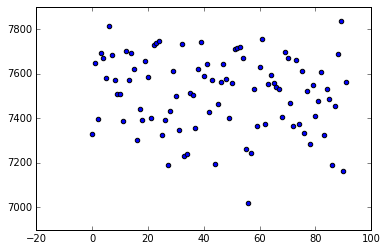

Initializer :  random
Selector :  roulette wheel
Recombiner :  single point crossover
Mutator :  random resetting
replacer :  elitist_replacer
6561


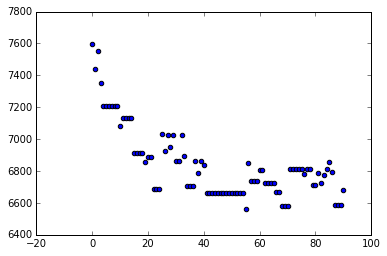

Initializer :  random
Selector :  roulette wheel
Recombiner :  single point crossover
Mutator :  creep mutator
replacer :  delete_all
6738


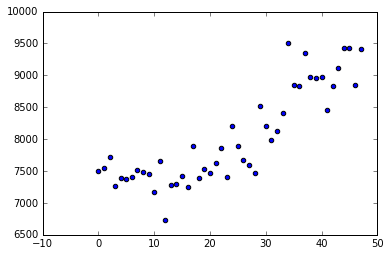

Initializer :  random
Selector :  roulette wheel
Recombiner :  single point crossover
Mutator :  creep mutator
replacer :  elitist_replacer
6034


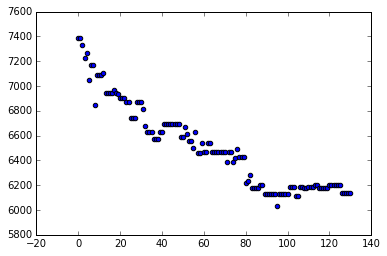

Initializer :  random
Selector :  roulette wheel
Recombiner :  uniform crossover
Mutator :  random resetting
replacer :  delete_all
7199


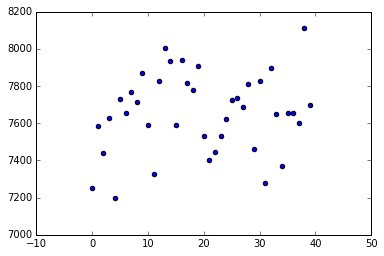

Initializer :  random
Selector :  roulette wheel
Recombiner :  uniform crossover
Mutator :  random resetting
replacer :  elitist_replacer
6523


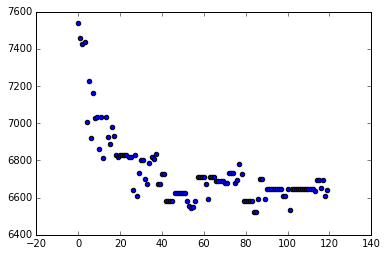

Initializer :  random
Selector :  roulette wheel
Recombiner :  uniform crossover
Mutator :  creep mutator
replacer :  delete_all
7152


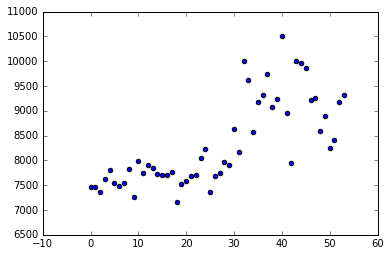

Initializer :  random
Selector :  roulette wheel
Recombiner :  uniform crossover
Mutator :  creep mutator
replacer :  elitist_replacer
6735


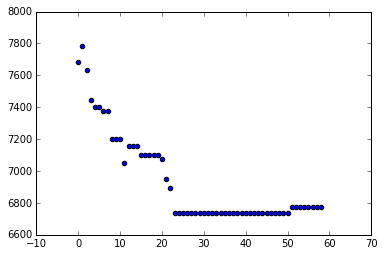

Initializer :  random
Selector :  tournament
Recombiner :  single point crossover
Mutator :  random resetting
replacer :  delete_all
6763


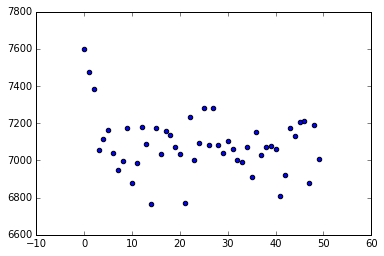

Initializer :  random
Selector :  tournament
Recombiner :  single point crossover
Mutator :  random resetting
replacer :  elitist_replacer
6333


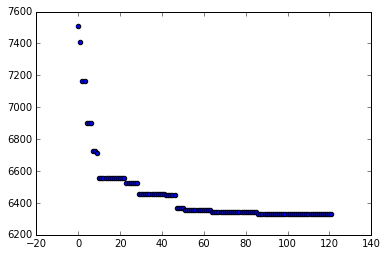

Initializer :  random
Selector :  tournament
Recombiner :  single point crossover
Mutator :  creep mutator
replacer :  delete_all
4303


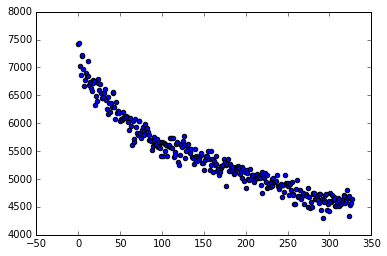

Initializer :  random
Selector :  tournament
Recombiner :  single point crossover
Mutator :  creep mutator
replacer :  elitist_replacer
6873


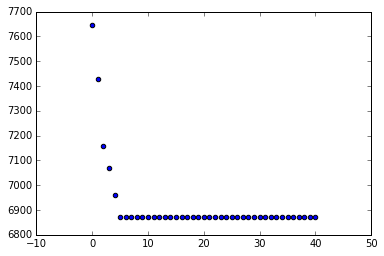

Initializer :  random
Selector :  tournament
Recombiner :  uniform crossover
Mutator :  random resetting
replacer :  delete_all
6578


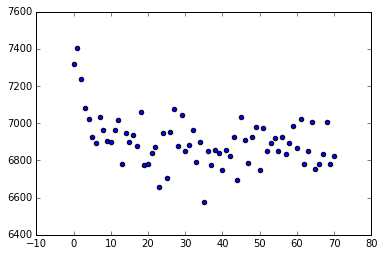

Initializer :  random
Selector :  tournament
Recombiner :  uniform crossover
Mutator :  random resetting
replacer :  elitist_replacer
6405


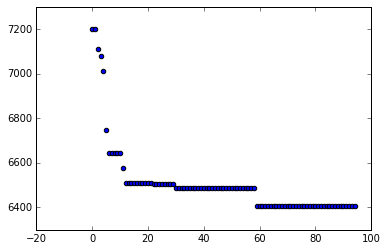

Initializer :  random
Selector :  tournament
Recombiner :  uniform crossover
Mutator :  creep mutator
replacer :  delete_all
6273


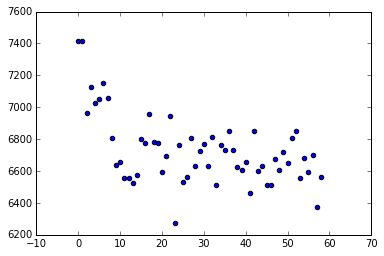

Initializer :  random
Selector :  tournament
Recombiner :  uniform crossover
Mutator :  creep mutator
replacer :  elitist_replacer
7249


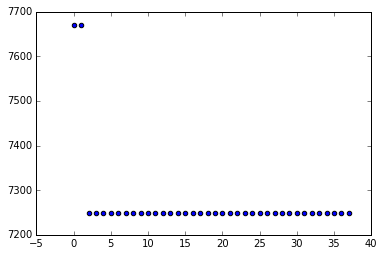

Initializer :  heuristic
Selector :  roulette wheel
Recombiner :  single point crossover
Mutator :  random resetting
replacer :  delete_all
5903


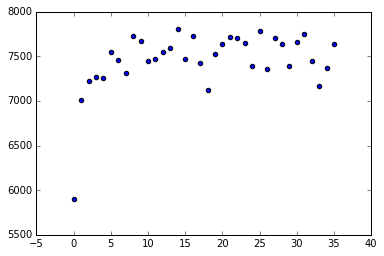

Initializer :  heuristic
Selector :  roulette wheel
Recombiner :  single point crossover
Mutator :  random resetting
replacer :  elitist_replacer
5903


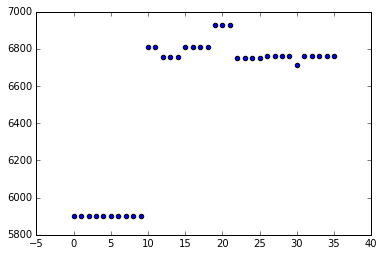

Initializer :  heuristic
Selector :  roulette wheel
Recombiner :  single point crossover
Mutator :  creep mutator
replacer :  delete_all
5903


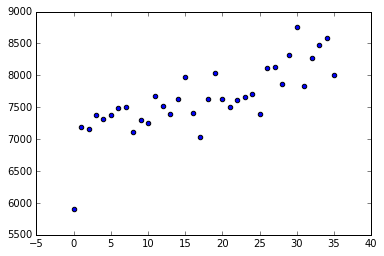

Initializer :  heuristic
Selector :  roulette wheel
Recombiner :  single point crossover
Mutator :  creep mutator
replacer :  elitist_replacer
5903


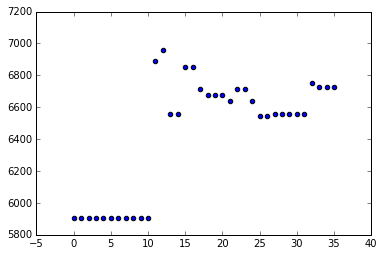

Initializer :  heuristic
Selector :  roulette wheel
Recombiner :  uniform crossover
Mutator :  random resetting
replacer :  delete_all
5903


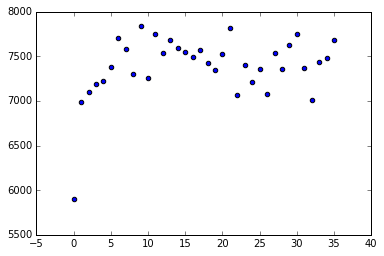

Initializer :  heuristic
Selector :  roulette wheel
Recombiner :  uniform crossover
Mutator :  random resetting
replacer :  elitist_replacer
5903


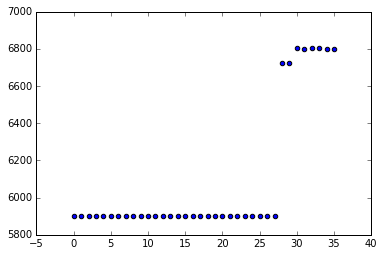

Initializer :  heuristic
Selector :  roulette wheel
Recombiner :  uniform crossover
Mutator :  creep mutator
replacer :  delete_all
5903


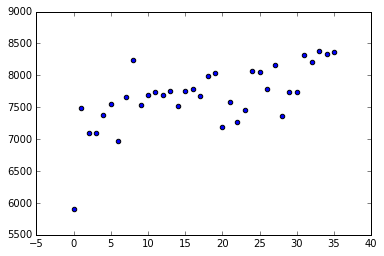

Initializer :  heuristic
Selector :  roulette wheel
Recombiner :  uniform crossover
Mutator :  creep mutator
replacer :  elitist_replacer
5903


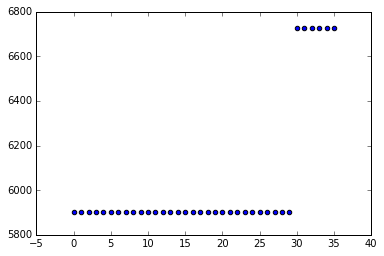

Initializer :  heuristic
Selector :  tournament
Recombiner :  single point crossover
Mutator :  random resetting
replacer :  delete_all
5903


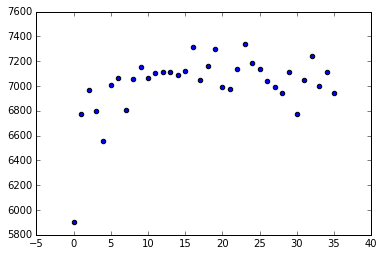

Initializer :  heuristic
Selector :  tournament
Recombiner :  single point crossover
Mutator :  random resetting
replacer :  elitist_replacer
5903


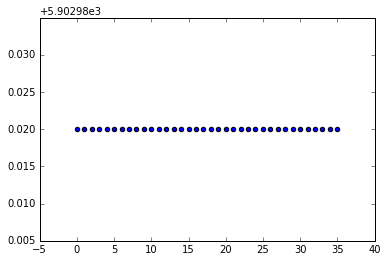

Initializer :  heuristic
Selector :  tournament
Recombiner :  single point crossover
Mutator :  creep mutator
replacer :  delete_all
5903


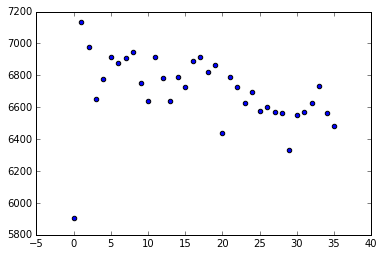

Initializer :  heuristic
Selector :  tournament
Recombiner :  single point crossover
Mutator :  creep mutator
replacer :  elitist_replacer
5903


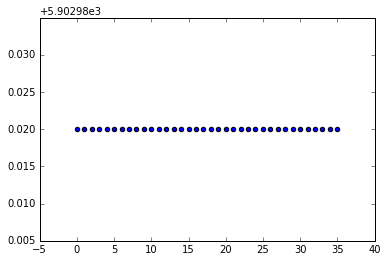

Initializer :  heuristic
Selector :  tournament
Recombiner :  uniform crossover
Mutator :  random resetting
replacer :  delete_all
5903


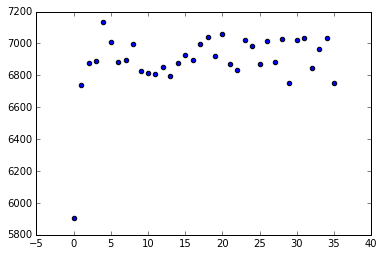

Initializer :  heuristic
Selector :  tournament
Recombiner :  uniform crossover
Mutator :  random resetting
replacer :  elitist_replacer
5903


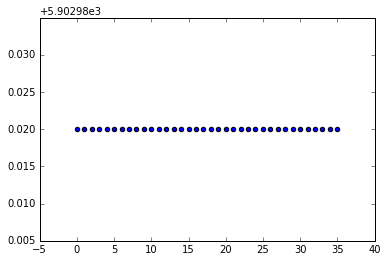

Initializer :  heuristic
Selector :  tournament
Recombiner :  uniform crossover
Mutator :  creep mutator
replacer :  delete_all
5903


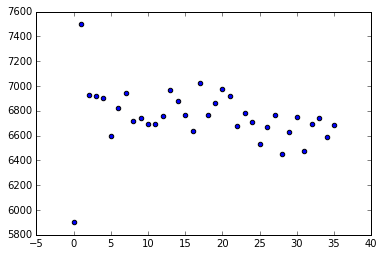

Initializer :  heuristic
Selector :  tournament
Recombiner :  uniform crossover
Mutator :  creep mutator
replacer :  elitist_replacer
5903


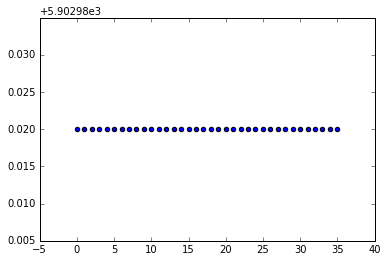

In [13]:
jobs1a = np.random.randint(10,1001,200)
jobs1b = np.random.randint(100,301,100)
jobs1 = np.concatenate([jobs1a,jobs1b])
jobs1 = list(jobs1)
machines1 = [i for i in range(1, 21)]
problem1 = Problem(machines1, jobs1, fitness)


for init in initializers:
    for selec in selectors:
        for recomb in recombiners:
            for mut in mutators:
                for repl in replacers:
                    #for m_rates in mutation_rates:
                    #   for c_rates in crossover_rates:
                     #       for p_sizes in pop_sizes:
                      #          for termin in termination:
                    genetic_algorithm = GeneticAlgo(problem1, initializer=init, selector=selec, recombiner=recomb, mutator=mut, replacer=repl)
                    print("Initializer : ", init)
                    print("Selector : ", selec)
                    print("Recombiner : ", recomb)
                    print("Mutator : ", mut)
                    print("replacer : ", repl)
                    #print("Mutation rate : ", m_rates)
                    #print("Crossover rate : ", c_rates)
                    #print("Population size : ", p_sizes)
                    #print("Termination : ", termin)
                    top_individuals, generationNr = genetic_algorithm.evolve()
                    fitnesses = [ind.fitness*-1 for ind in top_individuals]
                    print(min(fitnesses))
                    plt.figure()
                    plt.scatter(np.arange(generationNr+1), fitnesses)
                    plt.show()

# Problem 2


9505


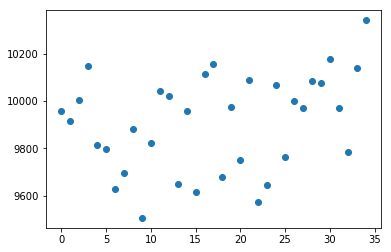

In [67]:
jobs2a = np.random.randint(10,1001,150)
jobs2b = np.random.randint(400,701,150)
jobs2 = np.concatenate([jobs2a,jobs2b])
jobs2 = list(jobs2)
machines2 = [i for i in range(1, 21)]
problem2 = Problem(machines2, jobs2, fitness)



genetic_algorithm = GeneticAlgo(problem2)
top_individuals, generationNr = genetic_algorithm.evolve()
fitnesses = [ind.fitness*-1 for ind in top_individuals]
print(min(fitnesses))
plt.scatter(np.arange(generationNr+1), fitnesses)
plt.show()


# Problem3

9136


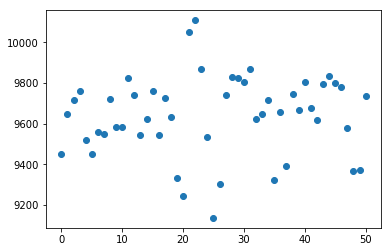

In [68]:
jobs3a = np.random.randint(10,1001,150)
jobs3b = np.random.randint(400,701,150)
jobs3 = np.concatenate([jobs3a,jobs3b])
jobs3 = list(jobs3)
machines3 = [i for i in range(1, 21)]
problem3 = Problem(machines3, jobs3, fitness)


genetic_algorithm = GeneticAlgo(problem3)
top_individuals, generationNr = genetic_algorithm.evolve()
fitnesses = [ind.fitness*-1 for ind in top_individuals]
print(min(fitnesses))
plt.scatter(np.arange(generationNr+1), fitnesses)
plt.show()

